In [2]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import optim
from torch.nn import functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import PIL
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
df = pd.read_csv("../input/age-gender-and-ethnicity-face-data-csv/age_gender.csv")
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [4]:
df["pixels"] = df["pixels"].apply(lambda x : np.reshape(np.array(x.split(),dtype = "float32"),(48,48)))

In [5]:
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 13..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[[164.0, 74.0, 111.0, 168.0, 169.0, 171.0, 175..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[[67.0, 70.0, 71.0, 70.0, 69.0, 67.0, 70.0, 79..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[[193.0, 197.0, 198.0, 200.0, 199.0, 200.0, 20..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[[202.0, 205.0, 209.0, 210.0, 209.0, 209.0, 21..."


In [6]:
df.iloc[0]

age                                                          1
ethnicity                                                    2
gender                                                       0
img_name                        20161219203650636.jpg.chip.jpg
pixels       [[129.0, 128.0, 128.0, 126.0, 127.0, 130.0, 13...
Name: 0, dtype: object

In [7]:
class dataset(Dataset):
    def __init__(self,df):
        self.df = df
        self.normalize = transforms.Normalize(mean = [0.485,0.456,0.406],std = [0.229,0.224,0.225])
    def __len__(self):
        return len(self.df)
    def __getitem__(self,ix):
        file = self.df.iloc[ix]
        age = torch.tensor(file.age / 116)
        gender = torch.tensor(file.gender).view(-1)
        eth = torch.tensor(file.ethnicity)
        im = file.pixels
        im = np.array(Image.fromarray(im).convert("RGB"))
        im = cv.resize(im,(224,224))
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255)
        
        return im.float().to(device),age.to(device),gender.float().to(device),eth.to(device)
        

In [8]:
msk = np.random.randn(len(df)) < 0.8
train = df[msk]
test = df[~msk]

In [9]:
train_new = dataset(train)
val_new = dataset(test)
train_loader = DataLoader(train_new,batch_size = 32,shuffle = True)
val_loader = DataLoader(val_new,batch_size = 32)

In [10]:
im,a,b,c = next(iter(val_loader))

In [11]:
import torchvision.models as models
model = models.vgg16(pretrained = True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [12]:
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.Sequential(
    nn.Conv2d(512,512,kernel_size = 3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten()
)


In [13]:
class AgeGenEthClassifier(nn.Module):
    def __init__(self):
        super(AgeGenEthClassifier,self).__init__()
        self.intermediate = nn.Sequential(
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(),
        )
        self.age_classifier = nn.Sequential(
            nn.Linear(64,1),
            nn.Sigmoid()
        )
        self.gender_classifier = nn.Sequential(
            nn.Linear(64,1),
            nn.Sigmoid()
        )
        self.eth_classifier = nn.Sequential(
            nn.Linear(64,5),
            nn.Softmax()
        )
        
    def forward(self,x):
        x = self.intermediate(x)
        age = self.age_classifier(x)
        gender = self.gender_classifier(x)
        eth = self.eth_classifier(x)
        
        return age.to(device),gender.to(device),eth.to(device)
        

In [14]:
model.classifier = AgeGenEthClassifier().to(device)

In [15]:
model = model.to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
age_criterion = nn.L1Loss().to(device)
gender_criterion = nn.BCELoss().to(device)
eth_criterion = nn.CrossEntropyLoss().to(device)

In [17]:
import time

In [18]:
n_epochs = 5
val_gender_accuracies = []
val_age_maes = []
val_eth_accuracies = []
train_losses = []
val_losses = []
best_test_loss = 1000
start = time.time()
for epochs in range(n_epochs):
    epoch_train_loss,epoch_val_loss = 0,0
    val_age_mae,val_gender_acc,val_eth_acc,ctr = 0,0,0,0
    for ix,data in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        im,age,gen,eth = data
        im = im.to(device)
        age = age.to(device)
        gen = gen.to(device)
        eth = eth.to(device)
        pred_age,pred_gen,pred_eth = model(im)
        age_loss = age_criterion(pred_age,age)
        gen_loss = gender_criterion(pred_gen,gen)
        eth_loss = eth_criterion(pred_eth,eth)
        total_loss = age_loss + gen_loss + eth_loss 
        total_loss.backward()
        optimizer.step()
        epoch_train_loss += total_loss.item()
    for ix,data in enumerate(val_loader):
        model.eval()
        im,age,gen,eth = data
        im = im.to(device)
        age = age.to(device)
        gen = gen.to(device)
        eth = eth.to(device)
        with torch.no_grad():
            pred_age,pred_gen,pred_eth = model(im)
        age_loss = age_criterion(pred_age,age)
        gen_loss = gender_criterion(pred_gen,gen)
        eth_loss = eth_criterion(pred_eth,eth)
        total_loss = age_loss + gen_loss + eth_loss 
        pred_gender = (pred_gen > 0.5)
        gender_acc = (pred_gender == gen).float()
        pred_eth = (pred_eth > 0.5)
        #eth_acc = (pred_eth == eth).float()
        age_mae = torch.abs(age - pred_age).float().sum()
        
        val_age_mae += age_mae
        epoch_val_loss += total_loss.item()
        #val_gender_acc += gender_acc
        #val_eth_acc += eth_acc
        ctr += len(data[0])
        
    val_age_mae /= ctr
    #val_gender_acc /= ctr
    #al_eth_acc /= ctr
    epoch_train_loss /= len(train_loader)
    epoch_val_loss /= len(val_loader)
    elapsed = time.time() - start
    best_test_loss = min(best_test_loss,epoch_val_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epochs+1, n_epochs, time.time()-start, (n_epochs-epochs)*(elapsed/(epochs+1))))
    info = f'''Epoch: {epochs+1} \tTrain Loss: {epoch_train_loss:.3f} \tTest: {epoch_val_loss:.3f} \tBest Test Loss: {best_test_loss:.4f}'''
    info += f'%\t Age MAE: \ {val_age_mae:.2f}'
    print(info)
    #val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)
    #val_eth_accuracies.append(val_eth_acc)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/loss.py:94: UserWarning: Using a target s

1/5 (169.74s - 848.71s remaining)
Epoch: 1 	Train Loss: 2.037 	Test: 1.852 	Best Test Loss: 1.8516%	 Age MAE: \ 4.51
2/5 (337.67s - 675.33s remaining)
Epoch: 2 	Train Loss: 1.776 	Test: 1.737 	Best Test Loss: 1.7368%	 Age MAE: \ 4.43
3/5 (505.49s - 505.49s remaining)
Epoch: 3 	Train Loss: 1.664 	Test: 1.732 	Best Test Loss: 1.7321%	 Age MAE: \ 4.32
4/5 (673.47s - 336.74s remaining)
Epoch: 4 	Train Loss: 1.560 	Test: 1.717 	Best Test Loss: 1.7165%	 Age MAE: \ 4.23
5/5 (841.45s - 168.29s remaining)
Epoch: 5 	Train Loss: 1.455 	Test: 1.707 	Best Test Loss: 1.7074%	 Age MAE: \ 4.28


In [19]:
!wget https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG

--2021-07-03 22:24:08--  https://www.dropbox.com/s/6kzr8l68e9kpjkf/5_9.JPG
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6kzr8l68e9kpjkf/5_9.JPG [following]
--2021-07-03 22:24:09--  https://www.dropbox.com/s/raw/6kzr8l68e9kpjkf/5_9.JPG
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3e82bf5038a1c8d153c948c63b.dl.dropboxusercontent.com/cd/0/inline/BRlrf71wzzySqJ_5deKXEh8StwE20PbdAsXmGbKRzmjcwYeqjw_RlfmUhmoamW8JMb4O3fXOkhspK4BgXZGiktkK3uxLQNl-R4yyUUV8FxnzIQ70p3f2TelR_YnznxLKIlyum5WahwZqGm5zFXsMPlom/file# [following]
--2021-07-03 22:24:09--  https://uc3e82bf5038a1c8d153c948c63b.dl.dropboxusercontent.com/cd/0/inline/BRlrf71wzzySqJ_5deKXEh8StwE20PbdAsXmGbKRzmjcwYeqjw_RlfmUhmoamW8JMb4O3fXOkhspK4BgXZGiktkK3uxLQNl-R4yyUUV8F

In [37]:
im = cv.imread("./5_9.JPG")
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
im = cv.resize(im,(224,224)) / 255
im = torch.tensor(im).permute(2,0,1).to(device)
im = train_new.normalize(im)

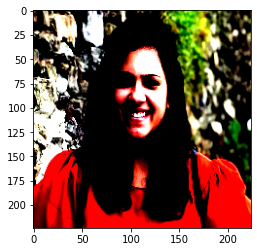

In [40]:
plt.imshow(im.permute(1,2,0).cpu().numpy())
age,gender,eth = model(im[None].float())


In [48]:
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
pred_eth = eth.to('cpu').detach().numpy()

In [56]:
pred_age * 116,pred_gender,pred_eth

(array([[14.3702965]], dtype=float32),
 array([[0.0001631]], dtype=float32),
 array([[8.62456858e-01, 2.63802917e-03, 1.09492965e-01, 2.54117046e-02,
         4.98289353e-07]], dtype=float32))

In [64]:
im,age,gen,eth = val_new[900]

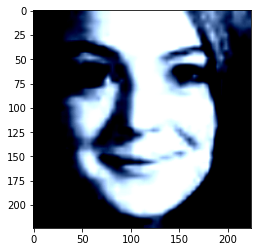

In [65]:
plt.imshow(im.cpu().permute(1,2,0).numpy())

In [66]:
age,gen,eth

(tensor(0.1897, device='cuda:0', dtype=torch.float64),
 tensor([1.], device='cuda:0'),
 tensor(0, device='cuda:0'))

In [67]:
age,gender,eth = model(im[None].float())

In [73]:
age*116,gender,eth

(tensor([[28.5302]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.9999]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[9.9998e-01, 3.0311e-09, 3.2637e-06, 2.0406e-05, 2.5092e-10]],
        device='cuda:0', grad_fn=<SoftmaxBackward>))

tensor(0.1983, device='cuda:0', dtype=torch.float64) tensor([1.], device='cuda:0') tensor(2, device='cuda:0')


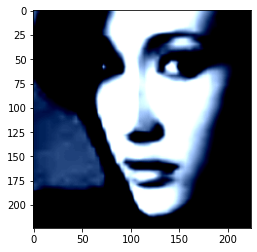

In [72]:
im1,age1,gen1,eth1 = val_new[990]
plt.imshow(im1.cpu().permute(1,2,0).numpy())
print(age1,gen1,eth1)

In [74]:
age_pred,gender_pred,eth_pred= model(im1[None].float())

In [75]:
age_pred*116,gender_pred,eth_pred

(tensor([[29.4487]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[0.9993]], device='cuda:0', grad_fn=<SigmoidBackward>),
 tensor([[1.3852e-02, 2.1719e-02, 7.2683e-01, 2.3755e-01, 4.2064e-05]],
        device='cuda:0', grad_fn=<SoftmaxBackward>))

In [77]:
!wget https://i.pinimg.com/originals/97/ed/6b/97ed6b370803649addbf66144c18c194.png

--2021-07-03 22:45:56--  https://i.pinimg.com/originals/97/ed/6b/97ed6b370803649addbf66144c18c194.png
Resolving i.pinimg.com (i.pinimg.com)... 184.29.84.193, 2600:1402:9800:98a::1931, 2600:1402:9800:996::1931, ...
Connecting to i.pinimg.com (i.pinimg.com)|184.29.84.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 865225 (845K) [image/png]
Saving to: ‘97ed6b370803649addbf66144c18c194.png’

97ed6b370803649addb 100%[===================>] 844.95K  1.51MB/s    in 0.5s    

2021-07-03 22:45:57 (1.51 MB/s) - ‘97ed6b370803649addbf66144c18c194.png’ saved [865225/865225]



In [78]:
im = cv.imread("./97ed6b370803649addbf66144c18c194.png")
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
im = cv.resize(im,(224,224)) / 255
im = torch.tensor(im).permute(2,0,1).to(device)
im = train_new.normalize(im)

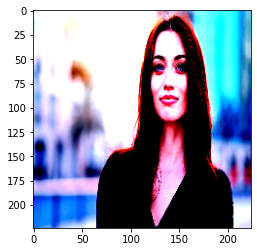

In [125]:
plt.imshow(im.permute(1,2,0).cpu().numpy())
age,gender,eth = model(im[None].float())

In [126]:
age = age*116,
if gender[0] > 0.5:
    gender = "Woman"
if eth.to('cpu').detach().numpy()[0][0] > 0.5:
    eth = "White"
print(f"Age : {age[0].to('cpu').detach().numpy()[0][0]:.0f}, Gender: {gender} , Ethnicity: {eth}")

Age : 19, Gender: Woman , Ethnicity: White
